Импорт библиотек

In [1]:
import os
import mlflow

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

Загрузить очищенную выборку. Разбить ее на тестовую и обучающую в пропорции 25%-75%

In [2]:
df = pd.read_pickle('D:\Загрузки2\LR_1_IIS\data\data_clear.pkl')
df = df.rename(columns={'Selling_Price': 'target'})
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.25, random_state=2)

Создать переменные, содержащие названия столбцов с числовыми и категориальными признаками

In [3]:
cat_features = X_train.select_dtypes(include=['category','object']).columns.to_list()
num_features = X_train.select_dtypes(include=['number']).columns.to_list()

Создать pipeline обработки признаков и обучения модели.

In [4]:
s_scaler = StandardScaler()
l_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=99999999) # unknown_value нужно выбирать с умом
regressor = RandomForestRegressor()

Обучить baseline-модель и получить метрики качества на тестовой выборке

In [5]:
# Для удобной работы со столбцами
preprocessor = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
    ],
    remainder='drop' ) # Удаляем столбцы, которые не затронуты преобразования

In [6]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),  ('model', regressor)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Year', 'Present_Price',
                                                   'Driven_kms']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Car_Name', 'Fuel_Type',
                                                   'Selling_type',
                                                   'Transmission', 'Owner',
                                                   'Driven_run'])])),
                ('model', RandomForestRegressor())])

In [7]:
predictions = pipeline.predict(X_test) 

metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 0.5113986842105264,
 'mape': 0.24257607502209802,
 'mse': 0.6658827527631582}

    Залогировать baseline-модель в новый эксперимент. Зарегистрировать модель.

In [8]:
# Работаем с MLflow локально
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

registry_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"

mlflow.set_tracking_uri(tracking_uri)   
mlflow.set_registry_uri(registry_uri)  

In [9]:
# название тестового эксперимента, запуска (run) внутри него, имени, под которым модель будет регистрироваться
EXPERIMENT_NAME = "estate_project"
RUN_NAME = "baseline model"
REGISTRY_MODEL_NAME = "estate_model_rf"

In [10]:
from mlflow.models import infer_signature
input_example = X_train.head(5)
signature =  infer_signature(model_input = X_train.head(5))

d:\Загрузки2\LR_1_IIS\.venv_my_proj\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [11]:
# Будем логировать requirements и артефакт - текстовый файл
req_file = '../requirements.txt'
art = '../comment.txt'
params_dict = pipeline.get_params()


In [12]:
# Когда создаем новый эксперимент, то: 
experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)

# Впоследствии. чтобы добавлять запуски в этот же эксепримент мы должны получить его id:
#experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(art)
    mlflow.log_params(params_dict)

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/21 10:52:29 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - pandas (current: 2.2.3, required: pandas==2.2.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
d:\Загрузки2\LR_1_IIS\.venv_my_proj\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024/11/21 10:52:29 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - pandas (current: 2.2.3, required: pandas==2.2.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies usi

🏃 View run baseline model at: http://127.0.0.1:5000/#/experiments/1/runs/89565fc470fb4a0d8338deb7a97219c1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


С использованием библиотеки sklearn создать дополнительные признаки, обучить модель, залогировать ее.

In [13]:
from sklearn.preprocessing import QuantileTransformer, SplineTransformer, PolynomialFeatures, MinMaxScaler

In [14]:
X_train_sklearn = X_train.copy()

In [15]:
pf = PolynomialFeatures(degree=2)

In [16]:
pf.fit_transform(X_train_sklearn[['Year','Driven_kms']])

array([[1.00000000e+00, 2.01700000e+03, 4.30000000e+03, 4.06828900e+06,
        8.67310000e+06, 1.84900000e+07],
       [1.00000000e+00, 2.01700000e+03, 4.10000000e+03, 4.06828900e+06,
        8.26970000e+06, 1.68100000e+07],
       [1.00000000e+00, 2.01600000e+03, 1.50590000e+04, 4.06425600e+06,
        3.03589440e+07, 2.26773481e+08],
       ...,
       [1.00000000e+00, 2.01300000e+03, 5.60010000e+04, 4.05216900e+06,
        1.12730013e+08, 3.13611200e+09],
       [1.00000000e+00, 2.01600000e+03, 4.30000000e+04, 4.06425600e+06,
        8.66880000e+07, 1.84900000e+09],
       [1.00000000e+00, 2.01300000e+03, 1.20000000e+04, 4.05216900e+06,
        2.41560000e+07, 1.44000000e+08]])

In [17]:
sp = SplineTransformer(n_knots=3, degree=3)

In [18]:
sp.fit_transform(X_train_sklearn[['Driven_kms']])

array([[1.59174223e-01, 6.66436925e-01, 1.74388264e-01, 5.87060755e-07,
        0.00000000e+00],
       [1.59562848e-01, 6.66460389e-01, 1.73976264e-01, 4.99159983e-07,
        0.00000000e+00],
       [1.39185616e-01, 6.63367490e-01, 1.97413878e-01, 3.30161856e-05,
        0.00000000e+00],
       ...,
       [7.84167130e-02, 6.22769436e-01, 2.96984763e-01, 1.82908835e-03,
        0.00000000e+00],
       [9.52392302e-02, 6.40172664e-01, 2.63766811e-01, 8.21294755e-04,
        0.00000000e+00],
       [1.44687491e-01, 6.64595243e-01, 1.90700995e-01, 1.62714322e-05,
        0.00000000e+00]])

In [19]:
qt = QuantileTransformer()

In [20]:
qt.fit_transform(X_train_sklearn[['Driven_kms']])

d:\Загрузки2\LR_1_IIS\.venv_my_proj\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (225). n_quantiles is set to n_samples.
  warnings.warn(


array([[0.06696429],
       [0.0625    ],
       [0.25892857],
       [0.55803571],
       [0.46205357],
       [0.99107143],
       [0.83482143],
       [0.21428571],
       [0.52232143],
       [0.71428571],
       [0.39732143],
       [0.70089286],
       [0.57142857],
       [0.41294643],
       [0.71428571],
       [0.63392857],
       [0.57589286],
       [0.17857143],
       [0.11383929],
       [0.9375    ],
       [0.42857143],
       [0.87946429],
       [0.53571429],
       [0.98660714],
       [0.15625   ],
       [0.1875    ],
       [0.3125    ],
       [0.77008929],
       [0.00892857],
       [0.54910714],
       [0.79464286],
       [0.36607143],
       [0.47544643],
       [0.20089286],
       [0.09375   ],
       [0.125     ],
       [0.77008929],
       [0.29910714],
       [0.45535714],
       [0.23883929],
       [0.61383929],
       [0.01785714],
       [0.44866071],
       [0.10267857],
       [0.02678571],
       [0.04464286],
       [0.13392857],
       [0.968

In [21]:
pf = PolynomialFeatures(degree=2)
qt = QuantileTransformer()
sp = SplineTransformer(n_knots=3, degree=3)

In [22]:
# Значения преобразованных признаков нужно отскейлить, поэтому создаем pipeline из двух шагов - преобразование и скейлинг
pf_pipeline = Pipeline(steps=[
    ('poly', pf),
    ('scale', StandardScaler())
])

In [23]:
preprocessor_sklearn = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
        ('quantile', qt,num_features),
        ('poly', pf_pipeline, ['Year', 'Driven_kms']), # В преобразования добавляем созданный ранее pipeline
        ('spline', sp, ['Driven_kms'])
    ],
    remainder='drop',
    ) # Удаляем столбцы, которые не затронуты преобразования

In [24]:
X_train_sklearn_raw = preprocessor_sklearn.fit_transform(X_train_sklearn)
X_train_sklearn = pd.DataFrame(X_train_sklearn_raw, columns=preprocessor_sklearn.get_feature_names_out())

d:\Загрузки2\LR_1_IIS\.venv_my_proj\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (225). n_quantiles is set to n_samples.
  warnings.warn(


In [25]:
# Удобно использовать для отображения всех строк\столбцов в DataFrame
with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
    display (X_train_sklearn)

,num__Year,num__Present_Price,num__Driven_kms,cat__Car_Name,cat__Fuel_Type,cat__Selling_type,cat__Transmission,cat__Owner,cat__Driven_run,quantile__Year,quantile__Present_Price,quantile__Driven_kms,poly__1,poly__Year,poly__Driven_kms,poly__Year^2,poly__Year Driven_kms,poly__Driven_kms^2,spline__Driven_kms_sp_0,spline__Driven_kms_sp_1,spline__Driven_kms_sp_2,spline__Driven_kms_sp_3,spline__Driven_kms_sp_4
0,1.171606,-0.812979,-0.797744,22.0,2.0,1.0,0.0,0.0,1.0,0.941964,0.017857,0.066964,0.0,1.171606,-0.797744,1.172873,-0.799057,-0.186065,0.159174,0.666437,0.174388,5.870608e-07,0.0
1,1.171606,-0.709078,-0.802502,34.0,2.0,1.0,1.0,0.0,1.0,0.941964,0.234375,0.062500,0.0,1.171606,-0.802502,1.172873,-0.803836,-0.186163,0.159563,0.666460,0.173976,4.991600e-07,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,0.828808,0.299637,0.122902,58.0,1.0,0.0,1.0,0.0,2.0,0.792411,0.785714,0.680804,0.0,0.828808,0.122902,0.829287,0.125216,-0.078957,0.095239,0.640173,0.263767,8.212948e-04,0.0
224,-0.199584,-0.789169,-0.614567,25.0,2.0,1.0,1.0,0.0,1.0,0.352679,0.098214,0.200893,0.0,-0.199584,-0.614567,-0.200450,-0.615625,-0.178721,0.144687,0.664595,0.190701,1.627143e-05,0.0


In [26]:
pipeline_sklearn = Pipeline(steps=[
    ('transform', preprocessor_sklearn),
    ('model', regressor)
])

model_sklearn = pipeline_sklearn.fit(X_train, y_train)

d:\Загрузки2\LR_1_IIS\.venv_my_proj\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (225). n_quantiles is set to n_samples.
  warnings.warn(


In [27]:
predictions = model_sklearn.predict(X_test) 
metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 0.5018605263157899,
 'mape': 0.2526837748633996,
 'mse': 0.5818183197368427}

In [28]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'fe_sklearn'
art = '../2 comment.txt'
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(model_sklearn, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(art)
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/21 10:52:55 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - pandas (current: 2.2.3, required: pandas==2.2.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024/11/21 10:52:55 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - pandas (current: 2.2.3, required: pandas==2.2.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


🏃 View run fe_sklearn at: http://127.0.0.1:5000/#/experiments/1/runs/74412d17c04043ae8105defc25fc1ba0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


С использованием библиотеки mlxtend отобрать N наиболее важных признаков. N выбирается с учетом количества признаков на предыдущем шаге, ориентировочный диапазон - от 20% до 70%. Обучить модель, залогировать ее.

In [29]:
from mlxtend.feature_selection import SequentialFeatureSelector 

In [30]:
sfs = SequentialFeatureSelector(RandomForestRegressor(n_estimators=3), 
                                k_features=3,
                                forward=True,
                                floating=False, # True to drop selected features
                                scoring='neg_mean_absolute_error',
                                cv=2)

sfs.fit(X_train_sklearn,y_train)

SequentialFeatureSelector(cv=2, estimator=RandomForestRegressor(n_estimators=3),
                          k_features=(3, 3), scoring='neg_mean_absolute_error')

In [31]:
selected_features_sfs = X_train_sklearn.loc[:, sfs.k_feature_names_]
selected_features_sfs

,num__Year,num__Present_Price,quantile__Present_Price
0,1.171606,-0.812979,0.017857
1,1.171606,-0.709078,0.234375
2,0.828808,0.051787,0.674107
3,-0.542382,0.149195,0.712054
4,0.486011,-0.207967,0.482143
...,...,...,...
220,0.486011,-0.132206,0.522321
221,-0.885179,-0.001246,0.638393
222,-0.199584,1.146004,0.917411
223,0.828808,0.299637,0.785714


In [32]:
rfe_sfs_idx = list(sfs.k_feature_idx_)
rfe_sfs_idx
rfe_sfs_col = list(sfs.k_feature_names_)
rfe_sfs_col

['num__Year', 'num__Present_Price', 'quantile__Present_Price']

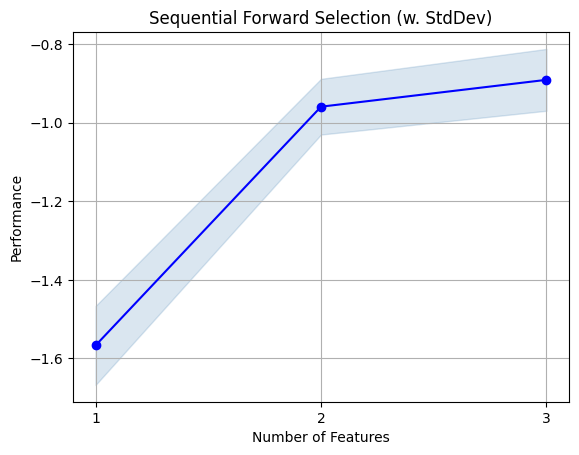

In [33]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [34]:
class ColumnExtractor(object):

    def __init__(self, cols):
        self.cols = cols

    def transform(self, X):
        return X[:,self.cols]
    
    def fit(self, X, y=None):
        return self

In [35]:
with open('rfe_skl_idx.txt', 'w+') as f:
    f.write(str(rfe_sfs_idx))
with open('rfe_skl_cols.txt', 'w+') as f:
    f.write(str(rfe_sfs_col))

In [36]:
rfe_sfs_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
    ('model', regressor)
])

rfe_sfs_pipeline.fit(X_train, y_train)

d:\Загрузки2\LR_1_IIS\.venv_my_proj\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (225). n_quantiles is set to n_samples.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Year', 'Present_Price',
                                                   'Driven_kms']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Car_Name', 'Fuel_Type',
                                                   'Selling_type',
                                                   'Transmission', 'Owner',
                                                   'Driven_run']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['Year', 'Present_Price',
                                                   'Driven_kms']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Year', 'Driven_kms']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['Driven_kms'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x0000018FEA0BBF10>),
                ('model', RandomForestRegressor())])

In [38]:
predictions_sfs = rfe_sfs_pipeline.predict(X_test)

metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions_sfs)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions_sfs)
metrics["mse"] = mean_squared_error(y_test, predictions_sfs)

metrics
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'rfe_sfs_feature_selection'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_sfs_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('rfe_skl_cols.txt')
    mlflow.log_artifact('rfe_skl_idx.txt')
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/21 10:53:14 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - pandas (current: 2.2.3, required: pandas==2.2.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024/11/21 10:53:14 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - pandas (current: 2.2.3, required: pandas==2.2.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


🏃 View run rfe_sfs_feature_selection at: http://127.0.0.1:5000/#/experiments/1/runs/38423caa38854ce4a45f6d4ec6450a07
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [39]:
metrics

{'mae': 0.5061029923767754,
 'mape': 0.177138849239739,
 'mse': 0.8086750223419465}

С помощью optuna настроить оптимальные параметры для модели, показывающей лучший результат. Обучить модель, залогировать ее, зарегистрировать очередную версию.

In [40]:
import optuna

In [44]:
def objective(trial):
    # предлагаем гиперпараметры
    depth = trial.suggest_int('depth', 1, 10)
    max_features = trial.suggest_float('max_features', 0.1, 1)
    n_estimators = trial.suggest_int('n_estimators', 1, 3)

    # создаём и обучаем модель
    opt_pipeline  = Pipeline(steps=[
        ('preprocessor', preprocessor_sklearn), 
        ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
        ('model',  RandomForestRegressor(n_estimators=n_estimators, max_depth=depth, max_features =max_features))
    ])

    opt_pipeline.fit(X_train, y_train)

    # предсказываем и вычисляем RMSE
    preds = opt_pipeline.predict(X_test)
    mae =  mean_absolute_error(y_test, preds)   

    return mae

In [45]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# выводим результаты
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params) 

[I 2024-11-21 10:53:24,349] A new study created in memory with name: no-name-15d7ea79-290e-4872-ad4c-10491ff4ce4d
d:\Загрузки2\LR_1_IIS\.venv_my_proj\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (225). n_quantiles is set to n_samples.
  warnings.warn(
[I 2024-11-21 10:53:24,374] Trial 0 finished with value: 1.7256086415672882 and parameters: {'depth': 2, 'max_features': 0.10413470510904727, 'n_estimators': 1}. Best is trial 0 with value: 1.7256086415672882.
d:\Загрузки2\LR_1_IIS\.venv_my_proj\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (225). n_quantiles is set to n_samples.
  warnings.warn(
[I 2024-11-21 10:53:24,391] Trial 1 finished with value: 0.5906489782147677 and parameters: {'depth': 8, 'max_features': 0.8175134589905131, 'n_estimators': 1}. Best is trial 1 with value: 0.5906489782147677.
d:\Загрузки2\LR_1_I

Number of finished trials: 10
Best trial: {'depth': 8, 'max_features': 0.5052449805697352, 'n_estimators': 3}


In [46]:
opt_pipeline  = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
    ('model', RandomForestRegressor(max_depth=8,max_features = 0.5052449805697352, n_estimators=3))
])

# Проведем стандартную проверку на тестовом множестве и залогируем run

In [47]:
rfe_sfs_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
    ('model', regressor)
])

rfe_sfs_pipeline.fit(X_train, y_train)

d:\Загрузки2\LR_1_IIS\.venv_my_proj\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (225). n_quantiles is set to n_samples.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Year', 'Present_Price',
                                                   'Driven_kms']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Car_Name', 'Fuel_Type',
                                                   'Selling_type',
                                                   'Transmission', 'Owner',
                                                   'Driven_run']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['Year', 'Present_Price',
                                                   'Driven_kms']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Year', 'Driven_kms']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['Driven_kms'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x0000018FEC28E850>),
                ('model', RandomForestRegressor())])

In [48]:
predictions = rfe_sfs_pipeline.predict(X_test) 
metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 0.5132905623433586,
 'mape': 0.17871734444573517,
 'mse': 0.7854170895045701}

In [49]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'optuna'
art = '../comment_after_optuna.txt'
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(model_sklearn, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(art)
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/21 10:53:46 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - pandas (current: 2.2.3, required: pandas==2.2.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024/11/21 10:53:46 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - pandas (current: 2.2.3, required: pandas==2.2.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024/11/21 10:53:46 WARNING mlflow.models.model: Failed to validate serving input example {
  "dataframe_split": {
    "columns": [
      "Car_Name",
      "Year",
      "Present_Price",
      "Driven_kms",
      "Fuel_Type"

🏃 View run optuna at: http://127.0.0.1:5000/#/experiments/1/runs/a0eeb82a77dd4f6da7febf2613046fe2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


Проанализировать все прогоны и выбрать модель, показывающую наилучшее качество. Обучить эту модель на всей выборке (а не только на train-части), залогировать ее.

In [50]:
df = pd.read_pickle('D:\Загрузки2\LR_1_IIS\data\data_clear.pkl')
df = df.rename(columns={'Selling_Price': 'target'})
Y = df['target']
X = df.drop('target', axis=1)

In [51]:
model_sklearn = pipeline_sklearn.fit(X, Y)

d:\Загрузки2\LR_1_IIS\.venv_my_proj\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (301). n_quantiles is set to n_samples.
  warnings.warn(


In [52]:
predictions = model_sklearn.predict(X_test) 
metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 0.15520921052631617,
 'mape': 0.05484379303119595,
 'mse': 0.07834448407894745}

In [53]:
# Самая лучшая модель
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'best_selection'
art = '../comment_best.txt'
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline_sklearn, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file,
                             registered_model_name = REGISTRY_MODEL_NAME
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(art)
    mlflow.log_params(pipeline_sklearn.get_params())

run = mlflow.get_run(run_id) 
run
assert (run.info.status =='FINISHED')

2024/11/21 10:56:30 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - pandas (current: 2.2.3, required: pandas==2.2.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024/11/21 10:56:30 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - pandas (current: 2.2.3, required: pandas==2.2.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
Successfully registered model 'estate_model_rf'.
2024/11/21 10:56:30 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: estate_model_rf, version 1
Cre

🏃 View run best_selection at: http://127.0.0.1:5000/#/experiments/1/runs/496c3d1f8a4a4fbf8569b37b3f73211c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [54]:
run

<Run: data=<RunData: metrics={'mae': 0.15520921052631617,
 'mape': 0.05484379303119595,
 'mse': 0.07834448407894745}, params={'memory': 'None',
 'model': 'RandomForestRegressor()',
 'model__bootstrap': 'True',
 'model__ccp_alpha': '0.0',
 'model__criterion': 'squared_error',
 'model__max_depth': 'None',
 'model__max_features': '1.0',
 'model__max_leaf_nodes': 'None',
 'model__max_samples': 'None',
 'model__min_impurity_decrease': '0.0',
 'model__min_samples_leaf': '1',
 'model__min_samples_split': '2',
 'model__min_weight_fraction_leaf': '0.0',
 'model__monotonic_cst': 'None',
 'model__n_estimators': '100',
 'model__n_jobs': 'None',
 'model__oob_score': 'False',
 'model__random_state': 'None',
 'model__verbose': '0',
 'model__warm_start': 'False',
 'steps': "[('transform', ColumnTransformer(transformers=[('num', "
          'StandardScaler(),\n'
          "                                 ['Year', 'Present_Price', "
          "'Driven_kms']),\n"
          "                             